## 2D Deconvolution on CUDA GPUs

In [1]:
using Pkg
Pkg.activate(".")

In [13]:
using Revise, DeconvOptim, TestImages, Noise, CUDA, ImageShow, Colors, FFTW
FFTW.set_num_threads(4)
CUDA.allowscalar(false);

h_view(args...) = begin
    img = cat(args..., dims=2)
    img ./= maximum(img)
    Gray.(img)
end

h_view (generic function with 1 method)

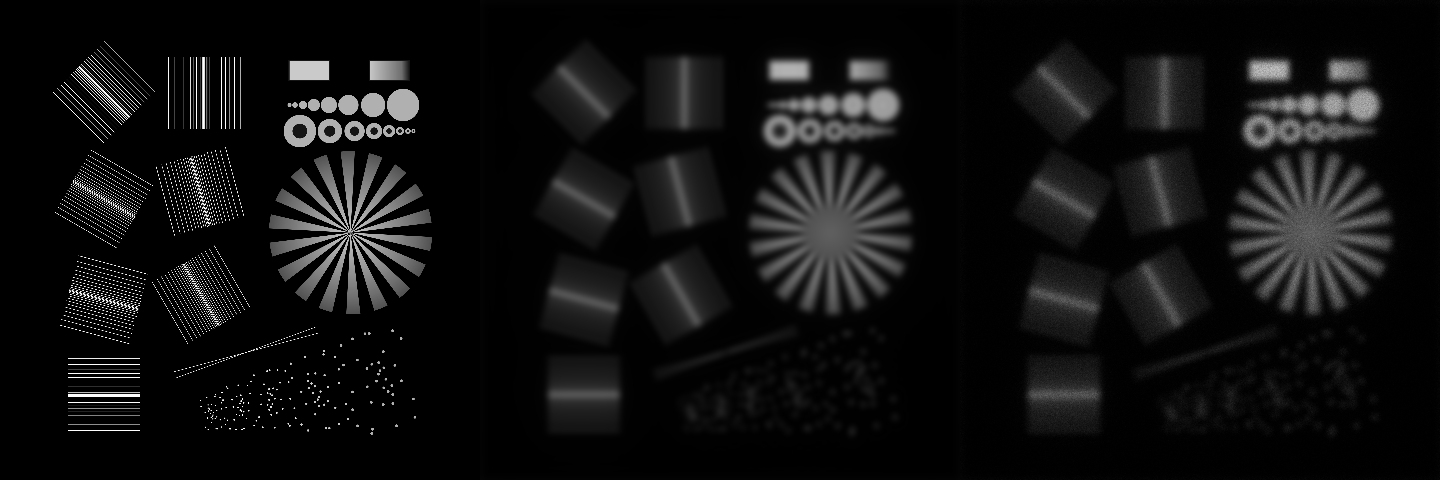

In [14]:
# load test images
img = Float32.(testimage("resolution_test_1920"))

psf = Float32.(generate_psf(size(img), 30))
psf_c = CuArray(psf)
# create a blurred, noisy version of that image
img_b = conv_psf(img, psf)
img_n = poisson(img_b, 300);

img_n_c = CuArray(img_n)
h_view(img, img_b, img_n)

In [4]:
reg = TV(mode="forward")

#140 (generic function with 1 method)

In [16]:
@time resG, optim_res = deconvolution(img_n, psf, loss=Poisson(), regularizer=reg, λ=0.005, iterations=20)

  5.996006 seconds (27.28 k allocations: 9.315 GiB, 9.88% gc time)


(Float32[0.039343078 0.038717743 … 0.03679252 0.03705969; 0.039096516 0.038376905 … 0.036880255 0.037056122; … ; 0.03949297 0.039726164 … 0.038234662 0.038412314; 0.039732784 0.039591234 … 0.038195975 0.043970685],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     7.374016e+05

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.12e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.70e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.88e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.25e-06 ≰ 0.0e+00
    |g(x)|                 = 4.01e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   6  (vs limit Inf)
    Iterations:    20
    f(x) calls:    26
    ∇f(x) calls:   21
)

In [6]:
reg_gpu = TV_cuda(num_dims=2)

#16 (generic function with 1 method)

In [25]:
CUDA.@time resG_c, optim_res_c = deconvolution(img_n_c, psf_c, loss=Poisson(), regularizer=reg_gpu, λ=0.005, iterations=20)

  0.485527 seconds (1.04 M CPU allocations: 19.038 MiB, 7.61% gc time) (2.20 k GPU allocations: 18.687 GiB, 29.84% gc time of which 71.51% spent allocating)


(Float32[0.03884971 0.03865241 … 0.03684757 0.037168477; 0.038894422 0.038393408 … 0.03687924 0.037101883; … ; 0.039437626 0.039492197 … 0.038295075 0.038540073; 0.04002083 0.039720956 … 0.038429957 0.043948755],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     7.374019e+05

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.77e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.39e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.56e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.83e-06 ≰ 0.0e+00
    |g(x)|                 = 4.05e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    20
    f(x) calls:    26
    ∇f(x) calls:   21
)

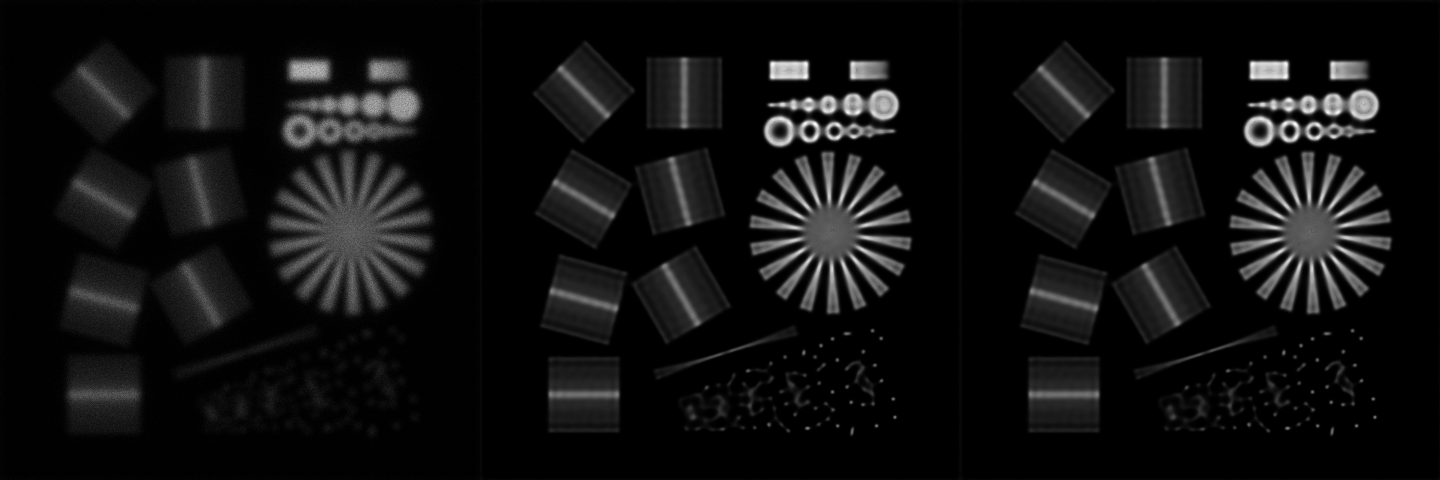

In [26]:
h_view(Array(img_n_c), Array(resG_c), Array(resG))

In [12]:
≈(Array(resG_c) .+ 1, Array(resG) .+ 1, rtol=1f-2)

true